In [1]:
from astropy.table import Table
from expansion_tools.delay_analysis import merge_lc
from astropy.table import Table
from astropy.units import Unit as u
import glob
import pickle
import copy

In [2]:
def get_sim_lcs(exp_lc_file,flare_lc_file,lc_name_1='lg_obs',lc_name_2='lr_obs_15GHz',beta_exp=None,radio_flux_offset=0,t_exp_extra=0,delta_correction=1):
    with open(exp_lc_file, 'rb') as f:
            lcs_v_exp=pickle.load(f)


    if 'beta_exp' in lcs_v_exp.keys() and beta_exp is None:
        lcs_v_exp['beta_exp']=lcs_v_exp['beta_exp']

        beta_exp=lcs_v_exp['beta_exp']

    print('beta_exp',beta_exp)
    print('-'*40)
    lc_2=lcs_v_exp[lc_name_2]
    lc_1=lcs_v_exp[lc_name_1]


    if flare_lc_file is not None:
        with open(flare_lc_file, 'rb') as f:
            lcs_flare=pickle.load(f)

            lc_1_flare=lcs_flare[lc_name_1]
            lc_2_flare=lcs_flare[lc_name_2]


        lc_1=merge_lc(lc_1_flare,lc_1)
        lc_2=merge_lc(lc_2_flare,lc_2)
    
    lc_1=copy.deepcopy(lc_1)
    lc_2=copy.deepcopy(lc_2)
    lc_1['flux']=lc_1['flux']*delta_correction**3
    lc_1['flux']=lc_1['flux']/lc_1['flux'].max()
    
    lc_1['time']=lc_1['time'].to('d')
    lc_1['time']=lc_1['time']/delta_correction
    
    lc_2['flux']=lc_2['flux']*delta_correction**3    
    lc_2['flux']=lc_2['flux']+(lc_2['flux'].max()*radio_flux_offset)
    lc_2['flux']=lc_2['flux']/lc_2['flux'].max()
  
    lc_2['time']=lc_2['time'].to('d').value+t_exp_extra
    lc_2['time']=lc_2['time']/delta_correction
    
    return lc_1,lc_2

In [3]:
def do_plot(fermi_lc,ovro_lc,lc_gamma,lc_radio,mjd_start_gamma,mjd_stop_gamma,mjd_start_radio,mjd_stop_radio,radio_offset=0):
    %matplotlib inline
    fig, axs = plt.subplots(1,dpi=100,figsize=(8,6))
    msk_f=fermi_lc['TS']>25
    msk_f=msk_f*(fermi_lc['tc']>mjd_start_gamma)
    msk_f=msk_f*(fermi_lc['tc']<mjd_stop_gamma)
    msk_o=ovro_lc['#mjd']>(mjd_start_radio)
    msk_o=msk_o*(ovro_lc['#mjd']<(mjd_stop_radio))

    x=fermi_lc['tc']
    y=fermi_lc['f']/fermi_lc['f'].max()
    y_err=y*(fermi_lc['df']/fermi_lc['f'])
    axs.errorbar(x ,y ,y_err, marker='o',ls='',color='blue',alpha=0.1)
    axs.errorbar(x[msk_f],y[msk_f],y_err[msk_f], marker='o',label='Fermi flare')


    x=ovro_lc['#mjd']
    y=ovro_lc['flux']/ovro_lc['flux'].max()
    y_err=y*(ovro_lc['flux err']/ovro_lc['flux'])
    axs.errorbar(x ,y ,y_err, marker='o',ls='',color='orange',alpha=0.2)
    axs.errorbar(x[msk_o],y[msk_o],y_err[msk_o], marker='o',label='15 GHz OVRO flare')

    axs.plot(lc_gamma['time']+mjd_simul_offset,lc_gamma['flux'],label='simulated Fermi flare')
    axs.plot(lc_radio['time']+mjd_simul_offset,lc_radio['flux']+radio_offset,label='simulated epansion 15 GHz flare')
    axs.set_xlim(mjd_start_gamma-10,mjd_stop_radio+10)
    axs.set_ylim(0.0,1.5)
    axs.set_xlabel(r'$t^{\rm obs}$ mjd')
    axs.set_ylabel('flux/(peak flux)')
    axs.legend()

In [4]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'same') / w

In [5]:
fermi='../radio_gev_data_and_analysis/data/mrk501/fermi/mrk501_7days.csv'
ovro='../radio_gev_data_and_analysis/data/mrk501/radio/J1653+3945.csv'
fermi_lc=Table.read(fermi)
ovro_lc=Table.read(ovro)

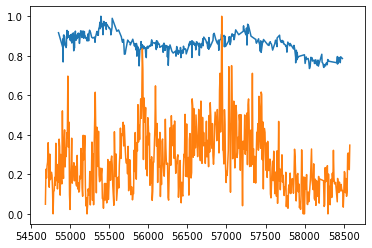

In [6]:
plt.plot(ovro_lc['#mjd'],ovro_lc['flux']/ovro_lc['flux'].max())
plt.plot(fermi_lc['tc'],fermi_lc['f']/fermi_lc['f'].max())

In [7]:
fermi='../radio_gev_data_and_analysis/data/mrk421/fermi/mrk421_1day.csv'
ovro='../radio_gev_data_and_analysis/data/mrk421/radio/J1104+3812.csv'
fermi_lc=Table.read(fermi)
ovro_lc=Table.read(ovro)

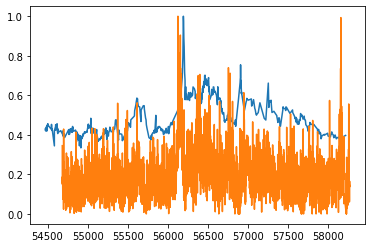

In [8]:
plt.plot(ovro_lc['#mjd'],ovro_lc['flux']/ovro_lc['flux'].max())
plt.plot(fermi_lc['tc'],fermi_lc['f']/fermi_lc['f'].max())

In [9]:
exp_dir='temp_ev_sim_exp_data_model_comparison/'
exp_sim_file_list=glob.glob('%s/lc_obs_beta_exp=*.pkl'%exp_dir)
exp_sim_file_list.sort()
exp_sim_file_list

['temp_ev_sim_exp_data_model_comparison/lc_obs_beta_exp=0.002.pkl',
 'temp_ev_sim_exp_data_model_comparison/lc_obs_beta_exp=0.003.pkl',
 'temp_ev_sim_exp_data_model_comparison/lc_obs_beta_exp=0.004.pkl',
 'temp_ev_sim_exp_data_model_comparison/lc_obs_beta_exp=0.005.pkl',
 'temp_ev_sim_exp_data_model_comparison/lc_obs_beta_exp=0.006.pkl']

In [10]:
exp_sim_temp_ev_file_list=glob.glob('%s/temp_ev_expansion_beta_exp*.pkl'%exp_dir)
exp_sim_temp_ev_file_list.sort()
exp_sim_temp_ev_file_list

['temp_ev_sim_exp_data_model_comparison/temp_ev_expansion_beta_exp=0.002.pkl',
 'temp_ev_sim_exp_data_model_comparison/temp_ev_expansion_beta_exp=0.003.pkl',
 'temp_ev_sim_exp_data_model_comparison/temp_ev_expansion_beta_exp=0.004.pkl',
 'temp_ev_sim_exp_data_model_comparison/temp_ev_expansion_beta_exp=0.005.pkl',
 'temp_ev_sim_exp_data_model_comparison/temp_ev_expansion_beta_exp=0.006.pkl']

In [11]:
flare_dir='temp_ev_sim_exp_data_model_comparison/'

flare_lc_file='%s/lc_obs_flare.pkl'%flare_dir
lc_name_1='lg_obs'
lc_name_2='lr_obs_15GHz'


beta_exp 0.004
----------------------------------------


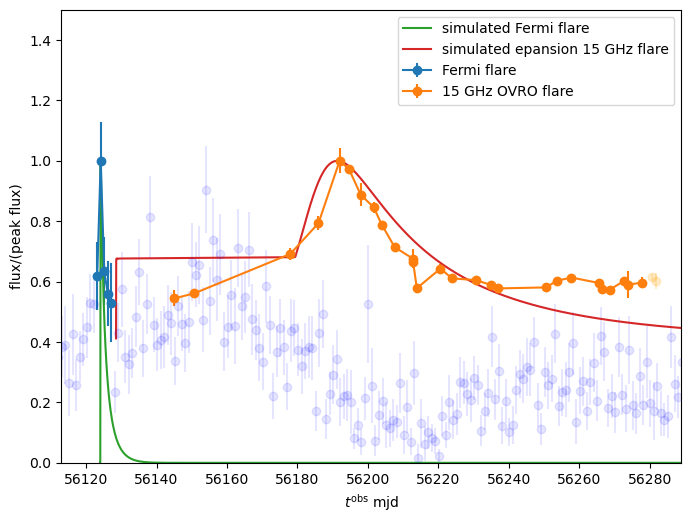

In [24]:
exp_lc_file=exp_sim_file_list[2]
temp_ev_file=exp_sim_temp_ev_file_list[2]
gamma_duration=5
delta_correction=2
mjd_start_gamma=56123
mjd_stop_gamma=mjd_start_gamma+gamma_duration

delta_t=66
radio_duration=90

mjd_start_radio=mjd_start_gamma+delta_t*0.2
mjd_stop_radio=mjd_start_gamma+delta_t+radio_duration

mjd_simul_offset=mjd_start_gamma+1


lc_gamma,lc_radio=get_sim_lcs(exp_lc_file,flare_lc_file,lc_name_2=lc_name_2,t_exp_extra=4.5,radio_flux_offset=0.7,delta_correction=1)
do_plot(fermi_lc,ovro_lc,lc_gamma,lc_radio,mjd_start_gamma,mjd_stop_gamma,mjd_start_radio,mjd_stop_radio)


In [13]:
from jetset.jet_timedep import JetTimeEvol
temp_ev_exp=JetTimeEvol.load_model(temp_ev_file)
temp_ev_acc_flare=JetTimeEvol.load_model('%s/temp_ev_acc_flare.pkl'%flare_dir)


beta_exp 0.004
----------------------------------------
t_max=0.13
t_max=62.78
Fm_r/Fm_g 1.0
t_start,t_stop  56.72763888888889 175.66463790131377
t_start,t_stop  56.72763888888889 175.66463790131377


/Users/orion/anaconda3/envs/jetset/lib/python3.8/site-packages/jetset/model_manager.py:147: UserWarning: no cosmology defined, using default FlatLambdaCDM(name="Planck13", H0=67.8 km / (Mpc s), Om0=0.307, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.0483)
  warnings.warn('no cosmology defined, using default %s'%self.cosmo)
/Users/orion/anaconda3/envs/jetset/lib/python3.8/site-packages/jetset/model_manager.py:147: UserWarning: no cosmology defined, using default FlatLambdaCDM(name="Planck13", H0=67.8 km / (Mpc s), Om0=0.307, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.0483)
  warnings.warn('no cosmology defined, using default %s'%self.cosmo)
/Users/orion/anaconda3/envs/jetset/lib/python3.8/site-packages/jetset/model_manager.py:147: UserWarning: no cosmology defined, using default FlatLambdaCDM(name="Planck13", H0=67.8 km / (Mpc s), Om0=0.307, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.0483)
  warnings.warn('no cosmology defined, using default %s

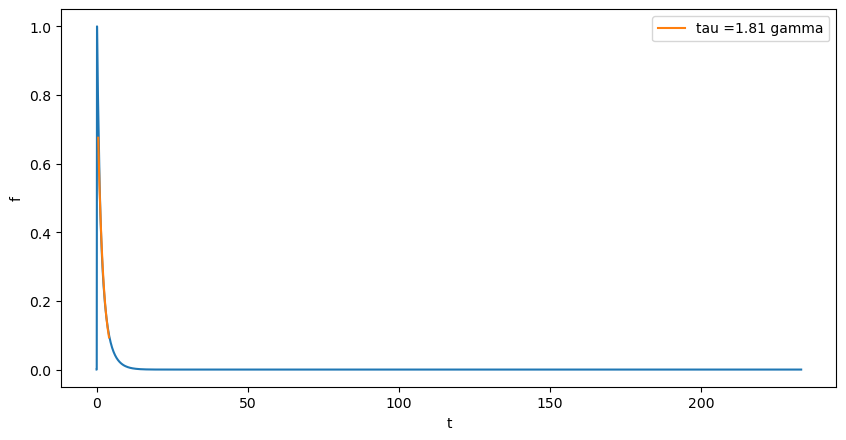

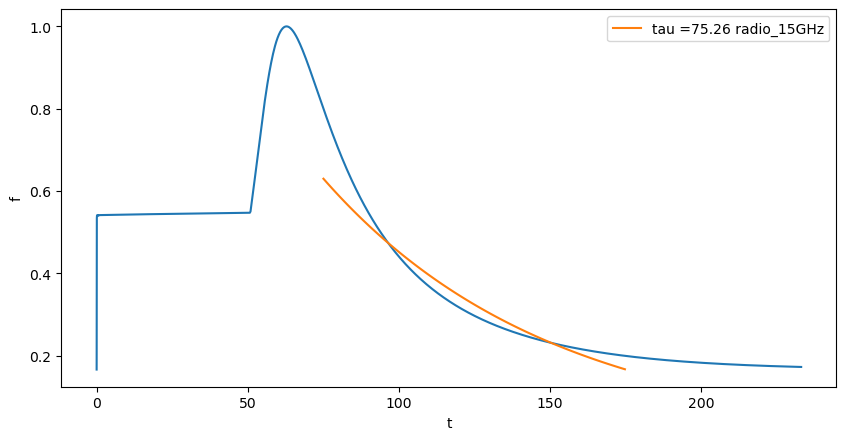

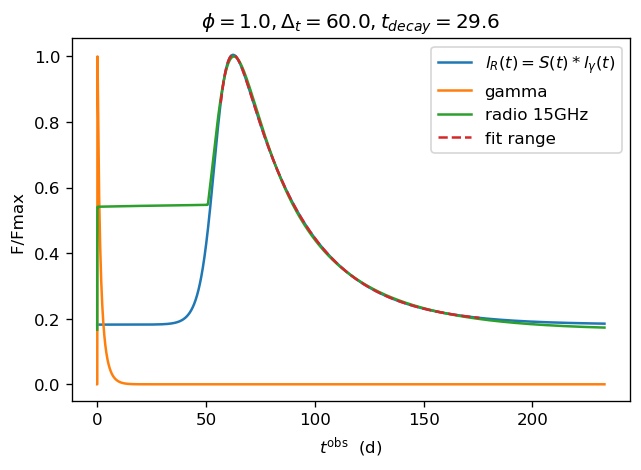

R at peak=9.304256e+15
----------------------------------------
delta_T_res=53.274946,delta_t_data=62.650463,delta_T_p=60.019778,Tp_radio=62.777778,Tp_gamma=0.127315
t_decay_conv,t_rise_conv,delta_t_conv 32.936904321922036 9.184361316527458 60.0197775125056


In [18]:
from expansion_tools.delay_analysis import gamma_radio_delay_fit
R0=temp_ev_acc_flare.rad_region.jet.parameters.R.val
delta=temp_ev_acc_flare.rad_region.jet.parameters.beam_obj.val
t_start_frac=0.55
t_stop_t_d_frac=1.5
t_exp=temp_ev_exp.parameters.t_jet_exp.val
beta_exp,delta_t,delta_t_conv,delta_t_conv_err,t_decay,t_decay_conv,t_decay_conv_err,t_rise_conv,t_rise_conv_err,t_peak_r,t_peak_g,fig_list = gamma_radio_delay_fit(exp_lc_file,'lg_obs',lc_name_2,flare_lc=flare_lc_file,t_start_frac=t_start_frac,t_stop_t_d_frac=t_stop_t_d_frac,phi_frozen=True,psi_frozen=True,max_points=5000,delta=delta,R0=R0,t_exp=t_exp,flare_duration=None,plot_single_lcs=True,radio_flux_offset=0.2)
print('t_decay_conv,t_rise_conv,delta_t_conv',t_decay_conv,t_rise_conv,delta_t_conv)

In [353]:
from expansion_tools.blob_expansion_tools_jetset gamma_radio_delay_fit
temp_ev_acc_flare=JetTimeEvol.load_model('temp_ev_sim_exp_data_model_comparison/temp_ev_expansion_beta_exp=0.004.pkl')

SyntaxError: invalid syntax (<ipython-input-353-284d496a4002>, line 1)

In [48]:
temp_ev_acc_flare.show_model()

--------------------------------------------------------------------------------
JetTimeEvol model description
--------------------------------------------------------------------------------
 
physical setup: 

--------------------------------------------------------------------------------


name,par type,val,units,val*,units*,log
delta t,time,1.000000e+03,s,0.005995849356279455,R/c,False
log. sampling,time,0.000000e+00,,None,,False
R/c,time,1.667820e+05,s,1.0,R/c,False
Diff coeff,,1.000000e-05,s-1,None,,False
Acc coeff,,1.000000e-04,s-1,None,,False
IC cooling,,off,,None,,False
Sync cooling,,on,,None,,False
Adiab. cooling,,on,,None,,False
Diff index,,2.000000e+00,,None,,False
Acc index,,1.000000e+00,s-1,None,,False



model parameters: 

--------------------------------------------------------------------------------


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_time_ev,duration,time_grid,s,5.317530e+08,0.000000e+00,--,False,True
jet_time_ev,gmin_grid,gamma_grid,,1.000000e+00,0.000000e+00,--,False,True
jet_time_ev,gmax_grid,gamma_grid,,1.000000e+08,0.000000e+00,--,False,True
jet_time_ev,gamma_grid_size,gamma_grid,,1.500000e+03,0.000000e+00,--,False,True
jet_time_ev,TStart_Acc,time_grid,s,0.000000e+00,0.000000e+00,--,False,True
jet_time_ev,TStop_Acc,time_grid,s,0.000000e+00,0.000000e+00,--,False,True
jet_time_ev,TStart_Inj,time_grid,s,0.000000e+00,0.000000e+00,--,False,True
jet_time_ev,TStop_Inj,time_grid,s,0.000000e+00,0.000000e+00,--,False,True
jet_time_ev,T_esc_acc,escape_time,(R_acc/c)*,1.500000e+01,--,--,False,True
jet_time_ev,T_esc_rad,escape_time,(R/c)*,1.000000e+60,--,--,False,True


In [54]:
(temp_ev_acc_flare.parameters.t_jet_exp.val-(86400))/1E8

1.242592